### В этом ноутбуке я обучил нейросеть resnet50 для предсказания одной из четырех меток. Используемый датасет - CAXTON
### Датасет CAXTON содержит примерно 1 млн помеченных картинок 
### Структура датасета: у каждого изображения есть 4 метки: 'flow_rate_class' (скорость подачи пластика) 'feed_rate_class' (скорость перемещения сопла), 'z_offset_class' (координата по вертикали), 'hotend_class' (температура)
### Каждая метка принимает три возможных значения: 0 (low), 1 (good), 2(high). То есть четыре параметра печати помечаются как слишком низкий, нормальный, слишком высокий. Авторы статьи сами произвели разбиение, на данный момент я не нашел критериев
### В данную работу (в среде jupiter notebook, kaggle) удалось загрузить примерно 13к картинок, ввиду ограничения на память на бесплатном аккаунте. Может быть, в дальнейшем смогу оптимальнее распределить память, но думаю что сильно больше чем 13к не удастся

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader
from skimage.io import imread
from torchvision import transforms, models
from skimage.transform import resize
import torch
import torch.nn as nn
from sklearn.metrics import f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Скачивание датасета, обработка изображений и меток для дальнейшей работы

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Resize(240, antialias=True),
    transforms.CenterCrop(224),      
    transforms.Normalize(            
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]  
    )
])

In [3]:
df = pd.DataFrame(columns=['image', 'flow_rate_class','feed_rate_class', 
                             'z_offset_class', 'hotend_class'])
images = []
df_index = 0   #индекс столбцов для заполения единого датафрема с изобр. и метками
name_data_dirname = 'print_log_filtered_classification3_gaps.csv'
for dirname, dirpath, filenames in os.walk('/kaggle/input/caxton-laptop'):
    if not filenames:
        continue
    data_dirname = pd.read_csv(os.path.join(dirname, name_data_dirname)) #таблица с данными печати для текущего архива
    image_index = 0   #индекс для обхода столбцов в локальном датафрейме data_dirname
    filenames.sort( key=lambda x: int(x[6:x.index('.')]) if x[-1]=='g' else -1 )  #сортировка по номеру изображения 'image-xxx.jpg'
    for file in filenames:
        if file == data_dirname.loc[image_index, 'img_path'].split(sep='/')[-1]:
            try:
                img = imread(os.path.join(dirname, file))
                img = transform(img)
                images.append(img)
                df.loc[df_index,'image'] = 'image' + str(image_index) + '.jpg'
                df.loc[df_index, ['flow_rate_class', 'feed_rate_class',
                                'z_offset_class', 'hotend_class']] = data_dirname.iloc[image_index, 12:]
                image_index += 1
                df_index += 1
                if image_index == data_dirname.shape[0]:  #выход из цикла, если достигнут конец внутренней таблицы
                    break
            except OSError:   #обработка исключения. в ходе загрузки выяснилось, что некоторые изображения повреждены и не загружаются
                print(f'{os.path.join(dirname, file)} did not read')
                image_index += 1
           

/kaggle/input/caxton-laptop/print0/print0/image-1130.jpg did not read
/kaggle/input/caxton-laptop/print0/print0/image-2777.jpg did not read


### Статистика по датасету, распределение по меткам

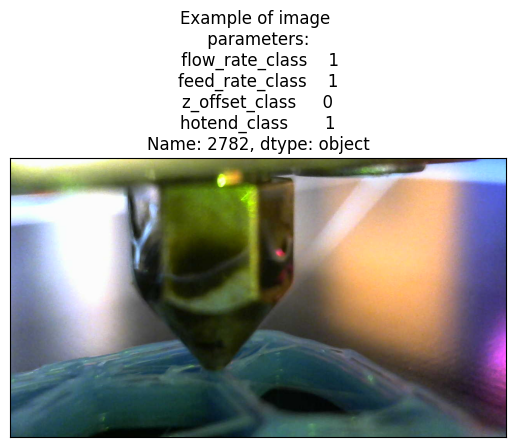

In [29]:
plt.imshow(imread('/kaggle/input/caxton-laptop/print0/print0/image-3084.jpg'))
str = f'Example of image \n parameters: \n {df.iloc[2782, 1:]}'
plt.title(str)
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
fl = df['flow_rate_class'].value_counts()
fe = df['feed_rate_class'].value_counts()
z = df['z_offset_class'].value_counts()
t = df['hotend_class'].value_counts()

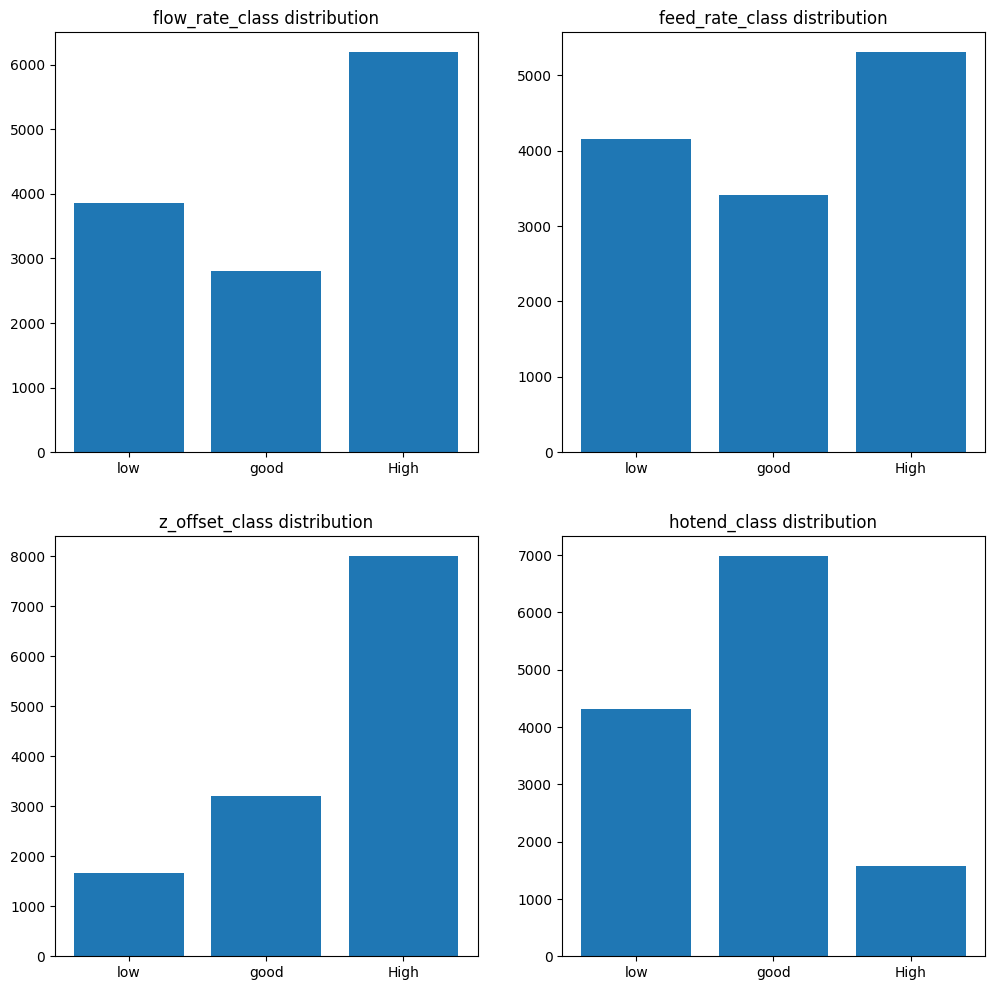

In [5]:
f, ax = plt.subplots(2,2, figsize=(12,12))
ax[0,0].bar(fl.index, fl.values)
ax[0,0].set_xticks([0,1, 2],['low','good', 'High'])
ax[0,0].set_title('flow_rate_class distribution')
ax[0,1].bar(fe.index, fe.values)
ax[0,1].set_xticks([0,1, 2],['low','good', 'High'])
ax[0,1].set_title('feed_rate_class distribution')
ax[1,0].bar(z.index, z.values)
ax[1,0].set_xticks([0,1, 2],['low','good', 'High'])
ax[1,0].set_title('z_offset_class distribution')
ax[1,1].bar(t.index, t.values)
ax[1,1].set_xticks([0,1, 2],['low','good', 'High'])
ax[1,1].set_title('hotend_class distribution')
plt.show()

### Продолжение работы с данными. Преобразование в формат, чтобы подавать на вход в нейросеть 

In [6]:
#совмещаю все изобр в единый tensor X, и создаю метки Y
X = torch.stack(images)
Y = df.iloc[:,1:].to_numpy(dtype=np.uint8)
#генерация индексов изображений для разбития датасета на train, val, test = 8 : 1 : 1
len_dataset = len(df['image']) 
ix = np.random.choice(len_dataset, len_dataset, replace=False)
val_size = int(0.1 * len_dataset)
tr, val, ts = np.split(ix, [val_size, 2*val_size])

In [7]:
batch_size = 32

data_tr = DataLoader(list(zip(X[tr], Y[tr])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(X[val], Y[val])),
                     batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(X[ts], Y[ts])),
                     batch_size=batch_size, shuffle=True)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Функция, обучающая нейросеть

In [9]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, history):
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss_tr = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch[:,0].to(device)
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward() 
            opt.step()  
            avg_loss_tr += loss / len(data_tr)
        history['train loss'].append(avg_loss_tr.detach().cpu().numpy())
        print('train loss: %f' % avg_loss_tr, end='  ')
        model.eval()
        avg_loss_val = 0
        for X_batch, Y_batch in data_val:
            Y_batch = Y_batch[:,0].to(device)
            X_batch = X_batch.to(device)
            Y_hat = model(X_batch)
            loss_val = loss_fn(Y_hat, Y_batch).detach().cpu()
            avg_loss_val += loss_val / len(data_val)
        history['val loss'].append(avg_loss_val.detach().cpu().numpy())     
        print('val loss: %f' % avg_loss_val)

### Загрузка предобученной модели resnet50 

In [10]:
model_resnet50_2 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model_resnet50_2.fc = nn.Linear(in_features=2048, out_features=3)#, bias=False) #предсказывает 3 логита: low(0), good(1), high(2) для одного из параметров печати
model_resnet50_2.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 74.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Первое обучение на 30 эпох, статистика

In [11]:
max_epochs = 30
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_resnet50_2.parameters(), lr=1e-4)
history_2 = {'train loss':[], 'val loss':[]}
train(model_resnet50_2, optim, loss_fn, max_epochs, data_tr, data_val, history_2)


* Epoch 1/30
train loss: 0.995001  val loss: 0.940912
* Epoch 2/30
train loss: 0.724426  val loss: 0.862787
* Epoch 3/30
train loss: 0.468913  val loss: 0.851089
* Epoch 4/30
train loss: 0.261286  val loss: 0.940559
* Epoch 5/30
train loss: 0.208116  val loss: 0.964727
* Epoch 6/30
train loss: 0.130865  val loss: 1.098070
* Epoch 7/30
train loss: 0.119740  val loss: 1.082144
* Epoch 8/30
train loss: 0.073660  val loss: 1.231893
* Epoch 9/30
train loss: 0.038514  val loss: 1.181153
* Epoch 10/30
train loss: 0.092556  val loss: 1.273630
* Epoch 11/30
train loss: 0.085142  val loss: 1.167542
* Epoch 12/30
train loss: 0.044511  val loss: 1.173756
* Epoch 13/30
train loss: 0.011676  val loss: 1.216184
* Epoch 14/30
train loss: 0.012366  val loss: 1.378595
* Epoch 15/30
train loss: 0.024487  val loss: 1.356522
* Epoch 16/30
train loss: 0.036763  val loss: 1.377149
* Epoch 17/30
train loss: 0.090556  val loss: 1.320916
* Epoch 18/30
train loss: 0.135470  val loss: 1.148160
* Epoch 19/30
train

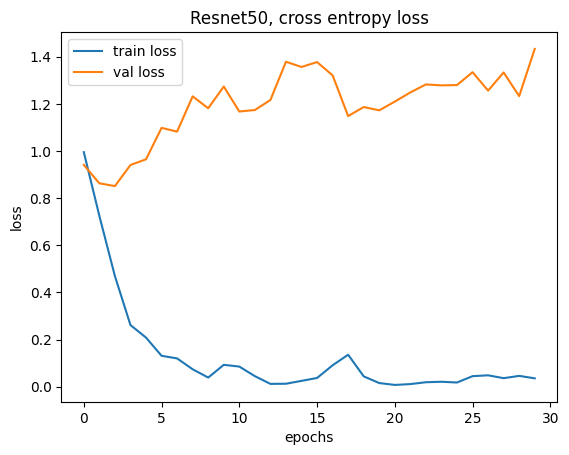

In [12]:
plt.plot(history_2['train loss'], label = 'train loss')
plt.plot(history_2['val loss'], label = 'val loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Resnet50, cross entropy loss')
plt.show()

### По результатам 1го обучения можно сделать вывод, что приблизительно после 3 эпохи модель переобучается. 
### Ниже - второе обучение на 3 эпохи

In [15]:
model_resnet50_s = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model_resnet50_s.fc = nn.Linear(in_features=2048, out_features=3)#, bias=False) #предсказывает 3 логита: low, good, high для одного из параметрво печати
model_resnet50_s.to(device)

max_epochs = 3
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_resnet50_s.parameters(), lr=5e-4)
history = {'train loss':[], 'val loss':[]}
train(model_resnet50_s, optim, loss_fn, max_epochs, data_tr, data_val, history)



* Epoch 1/3
train loss: 0.971909  val loss: 0.978312
* Epoch 2/3
train loss: 0.865735  val loss: 1.060701
* Epoch 3/3
train loss: 0.703538  val loss: 0.859691


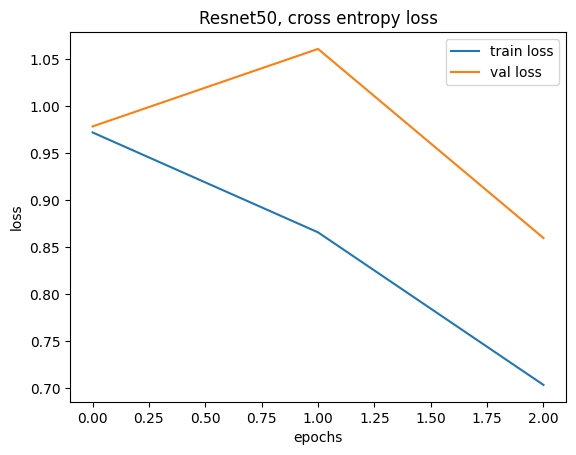

In [16]:
plt.plot(history['train loss'], label = 'train loss')
plt.plot(history['val loss'], label = 'val loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Resnet50, cross entropy loss')
plt.show()

### Предсказания на тестовой выборке

In [17]:
def predict(model, test_loader):    #функция, возвращающая предсказания обученной нейросети и истинные метки
    with torch.no_grad():
        label = []
        pred = []

        for inputs in test_loader:
            inputs_X = inputs[0].to(device)
            model.eval()
            class_from_logits = np.argmax(model(inputs_X).cpu(), -1)
            pred.append(class_from_logits)
            label.append(inputs[1][:, 0])
    return np.concatenate(pred), np.concatenate(label)

### Выводы: подсчет точности предсказаний resnet50

In [18]:
pred, label = predict(model_resnet50_s, data_ts)

In [19]:
print(f"f1_score of resnet50: {f1_score(pred, label, average='macro'):.2f}")

f1_score of resnet50: 0.56


In [20]:
print(f"the proportion of correct predictions of resnet50: {(pred==label).sum() / len(label):.2f}")

the proportion of correct predictions of resnet50: 0.62
